Data Preprocessing

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scalecast.Forecaster import Forecaster
%matplotlib inline

mtalbert = pd.read_csv('../Data/soil data/AcrossAucklandRainfallStation/MtAlbert_Data_15mins.csv', index_col=['Timestamp (UTC+12:00)'], parse_dates=['Timestamp (UTC+12:00)'])
mtalbert.head()


,Rain(mm),SoilTemp(c),SoilMoisture(%)
Timestamp (UTC+12:00),,,
2018-07-07 11:15:00,0.0,10.4,37.364
2018-07-07 11:30:00,0.0,10.4,37.594
2018-07-07 11:45:00,0.0,10.4,37.590
2018-07-07 12:00:00,0.0,10.5,37.587
2018-07-07 12:15:00,0.0,10.5,37.584


In [165]:
mtalbert.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187529 entries, 2018-07-07 11:15:00 to 2024-10-21 20:00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Rain(mm)         187529 non-null  float64
 1   SoilTemp(c)      187529 non-null  float64
 2   SoilMoisture(%)  187529 non-null  float64
dtypes: float64(3)
memory usage: 5.7 MB


In [166]:
print(mtalbert.isnull().sum())


Rain(mm)           0
SoilTemp(c)        0
SoilMoisture(%)    0
dtype: int64


In [167]:
mtalbert.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187529 entries, 2018-07-07 11:15:00 to 2024-10-21 20:00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Rain(mm)         187529 non-null  float64
 1   SoilTemp(c)      187529 non-null  float64
 2   SoilMoisture(%)  187529 non-null  float64
dtypes: float64(3)
memory usage: 5.7 MB


In [168]:
mtalbert['SoilMoisture(%)'].isna().sum()

0

In [169]:

mtalbert_daily = mtalbert.resample('D').agg({
    'SoilMoisture(%)': 'mean',
    'SoilTemp(c)': 'mean',
    'Rain(mm)': 'sum'
})
mtalbert_daily.head()

,SoilMoisture(%),SoilTemp(c),Rain(mm)
Timestamp (UTC+12:00),,,
2018-07-07,37.337412,11.064706,0.00
2018-07-08,36.910969,11.355208,7.36
2018-07-09,40.972479,12.148958,19.99
2018-07-10,42.747948,11.923958,7.88
2018-07-11,42.727272,11.422581,0.53


<Axes: xlabel='Timestamp (UTC+12:00)'>

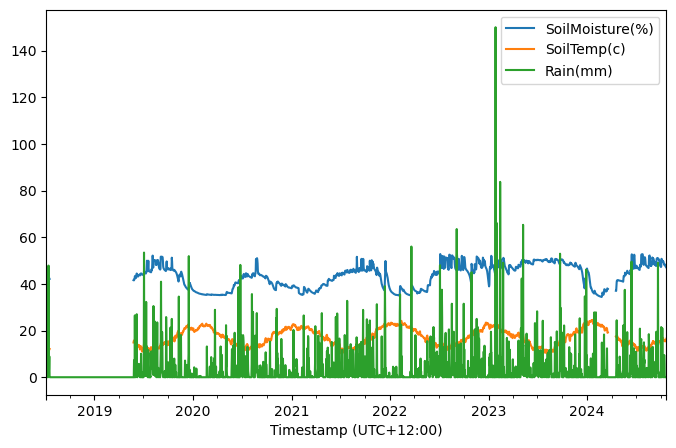

In [170]:
mtalbert_daily.plot(figsize=(8, 5))

In [171]:
mtalbert_daily.describe()

,SoilMoisture(%),SoilTemp(c),Rain(mm)
count,1961.000000,1961.000000,2299.000000
mean,43.447061,17.074853,3.167938
std,5.144707,3.636356,7.896574
min,34.390510,10.078125,0.000000
25%,38.478781,13.839583,0.000000
50%,44.250302,16.707292,0.000000
75%,47.641365,20.357292,2.525000
max,52.789979,24.555208,150.000000


In [172]:
mtalbert_daily.head(5)

,SoilMoisture(%),SoilTemp(c),Rain(mm)
Timestamp (UTC+12:00),,,
2018-07-07,37.337412,11.064706,0.00
2018-07-08,36.910969,11.355208,7.36
2018-07-09,40.972479,12.148958,19.99
2018-07-10,42.747948,11.923958,7.88
2018-07-11,42.727272,11.422581,0.53


Lag Features

In [173]:
rain_lag_size = [ 60] 

# Create lag features for 'Rainfall (mm)'
for i in rain_lag_size:
    mtalbert_daily[f'Rainfall_lag_{i}'] = mtalbert_daily['Rain(mm)'].shift(i)


# # Create lag features for 'SoilTemp'
# for i in lag_size:
#     mtalbert_daily[f'SoilTemp(c)_lag_{i}'] = mtalbert_daily['SoilTemp(c)'].shift(i)

mtalbert_daily.dropna(inplace=True)  # Drop rows with NaN values in the lag features

Split Data

In [174]:
print(mtalbert_daily.columns)


Index(['SoilMoisture(%)', 'SoilTemp(c)', 'Rain(mm)', 'Rainfall_lag_60'], dtype='object')


In [175]:
from sklearn.model_selection import train_test_split

# Define features and target
X = mtalbert_daily.drop(columns=['SoilMoisture(%)'])
y = mtalbert_daily['SoilMoisture(%)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Model

In [177]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping


lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the LSTM model
history = lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)


# Make predictions
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = lstm_predictions.flatten()

c:\Users\Ying\.conda\envs\level8\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 1928.7698 - val_loss: 1788.0132
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1754.6434 - val_loss: 1597.4603
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1542.4329 - val_loss: 1394.0917
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1360.8674 - val_loss: 1216.2290
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1171.6808 - val_loss: 1060.2958
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1015.6359 - val_loss: 904.6876
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 882.4104 - val_loss: 761.6078
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 735.3787 - val_loss: 650.6353
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 637.8885 - val_loss: 564.8169
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 557.6175 - val_loss: 493.4082
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 480.2437 - val_loss: 432.1027
Epoch 12/100
39/39 

In [178]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Make predictions on the training set
train_lstm_predictions = lstm_model.predict(X_train_lstm)
train_lstm_predictions = train_lstm_predictions.flatten()


# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, lstm_predictions))

# Calculate MAE
mae = mean_absolute_error(y_test, lstm_predictions)

# Calculate MSE
mse = mean_squared_error(y_test, lstm_predictions)

# Calculate R2 score
r2 = r2_score(y_test, lstm_predictions)

# Print the metrics
print("LSTM Root Mean Squared Error (RMSE):", rmse)
print("LSTM Mean Absolute Error (MAE):", mae)
print("LSTM Mean Squared Error (MSE):", mse)
print("LSTM R2 Score:", r2)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
LSTM Root Mean Squared Error (RMSE): 5.114059771779222
LSTM Mean Absolute Error (MAE): 4.468226968821311
LSTM Mean Squared Error (MSE): 26.15360734933055
LSTM R2 Score: -0.009358024121908226


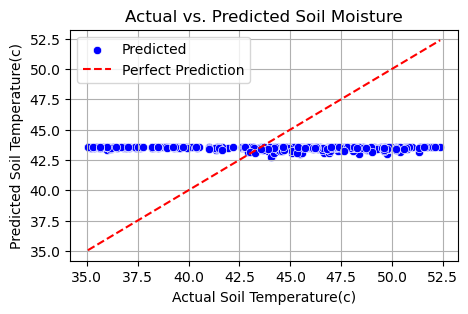

In [179]:
y_test_df = pd.DataFrame(y_test.reset_index(drop=True), columns=['SoilMoisture(%)'])
predictions_df = pd.DataFrame(lstm_predictions, columns=['Predicted'])

results_df = pd.concat([y_test_df, predictions_df], axis=1)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=results_df['SoilMoisture(%)'], y=results_df['Predicted'], color='blue', label='Predicted')
plt.plot([results_df['SoilMoisture(%)'].min(), results_df['SoilMoisture(%)'].max()], 
         [results_df['SoilMoisture(%)'].min(), results_df['SoilMoisture(%)'].max()], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs. Predicted Soil Moisture')
plt.xlabel('Actual Soil Temperature(c)')
plt.ylabel('Predicted Soil Temperature(c)')
plt.legend()
plt.grid()
plt.show()

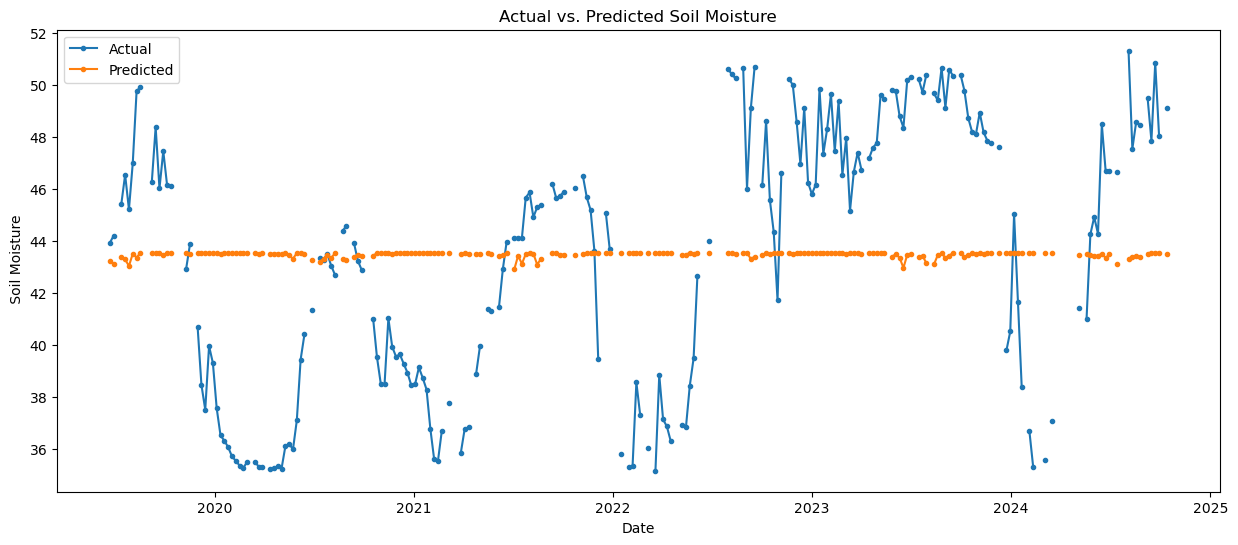

In [180]:
import matplotlib.pyplot as plt

# Create a DataFrame with actual and predicted values
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': lstm_predictions}, index=X_test.index)

# Resample data to a weekly frequency
result_df_weekly = result_df.resample('W').mean()

# Plotting actual vs. predicted values using subplots
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(result_df_weekly.index, result_df_weekly['Actual'], label='Actual', marker='.')
ax.plot(result_df_weekly.index, result_df_weekly['Predicted'], label='Predicted', marker='.')

ax.set_title('Actual vs. Predicted Soil Moisture')
ax.set_xlabel('Date')
ax.set_ylabel(' Soil Moisture')
ax.legend()
plt.savefig('rf_long_predict', dpi=300)

plt.show()